In [1]:
%matplotlib inline

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import torch

from classes.DQNagentClass import DQNAgent, DDQNAgent
from envs.createEnvs import createNNEnv
from utilities.plots import create_dicts_DQN, create_grids, plot_string_policy

In [3]:
env = createNNEnv()

Loading models...
Models loaded


In [4]:
def trainAgent(agent, path_to_save, n_episodes = 500, max_t = 3000, eps_start = 1.0, eps_end = 0.01, eps_decay = 0.996):
    """Deep Q-Learning
    Params
    ======
        n_episodes (int): maximum number of training epsiodes
        max_t (int): maximum number of timesteps per episode
        eps_start (float): starting value of epsilon, for epsilon-greedy action selection
        eps_end (float): minimum value of epsilon 
        eps_decay (float): mutiplicative factor (per episode) for decreasing epsilon
    """
    scores = [] # list containing score from each episode
    durations = [] # list containing duration of each episode
    eps = eps_start

    for i_episode in range(1, n_episodes+1):
        state,_ = env.reset()
        score = 0
        for t in range(1, max_t+1):
            action = agent.act(state,eps)
            #print("State: ", state,"Action: ",action)
            next_state,reward,done,_,_ = env.step(action)
            agent.step(state,action,reward,next_state,done)
            ## above step decides whether we will train(learn) the network actor (local_qnetwork) or we will fill the replay buffer
            ## if len replay buffer is equal to the batch size then we will train the network or otherwise we will add experience tuple in our replay buffer.
            state = next_state
            score += reward

            if done or t == max_t:
                print('Episode: {}\tSteps: {}'.format(i_episode,t))
                scores.append(score)
                durations.append(t)
                break

            eps = max(eps*eps_decay,eps_end)## decrease the epsilon

    # save the model weights
    torch.save(agent.qnetwork_local.state_dict(), path_to_save)

    return scores, durations

In [5]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
#print(device)
#print(env.action_space.n, env.observation_space.shape[0])

#Si cambio los seed de los agentes superan muchas veces el max_t de 200
dqnagent1 = DQNAgent(state_size=env.observation_space.shape[0], action_size=env.action_space.n, seed=0, fc1_unit=64, fc2_unit=64)
dqnagent2 = DQNAgent(state_size=env.observation_space.shape[0], action_size=env.action_space.n, seed=0, fc1_unit=64, fc2_unit=128)
dqnagent3 = DQNAgent(state_size=env.observation_space.shape[0], action_size=env.action_space.n, seed=0, fc1_unit=128, fc2_unit=64)
dqnagent4 = DQNAgent(state_size=env.observation_space.shape[0], action_size=env.action_space.n, seed=0, fc1_unit=128, fc2_unit=128)
dqnagent5 = DQNAgent(state_size=env.observation_space.shape[0], action_size=env.action_space.n, seed=0, fc1_unit=128, fc2_unit=128)

ddqnagent1 = DDQNAgent(state_size=env.observation_space.shape[0], action_size=env.action_space.n, seed=0, fc1_unit=64, fc2_unit=64)
ddqnagent2 = DDQNAgent(state_size=env.observation_space.shape[0], action_size=env.action_space.n, seed=0, fc1_unit=64, fc2_unit=128)
ddqnagent3 = DDQNAgent(state_size=env.observation_space.shape[0], action_size=env.action_space.n, seed=0, fc1_unit=128, fc2_unit=64)
ddqnagent4 = DDQNAgent(state_size=env.observation_space.shape[0], action_size=env.action_space.n, seed=0, fc1_unit=128, fc2_unit=128)
ddqnagent5 = DDQNAgent(state_size=env.observation_space.shape[0], action_size=env.action_space.n, seed=0, fc1_unit=128, fc2_unit=128)

agents_arr = [dqnagent1, dqnagent2, dqnagent3, dqnagent4, dqnagent5, ddqnagent1, ddqnagent2, ddqnagent3, ddqnagent4, ddqnagent5]
scores_arr = []
durations_arr = []

In [6]:
#TRAINING
train = False
NUM_DQN_AGENTS = 5
NUM_DDQN_AGENTS = 5

if train:
    for agent in agents_arr:
        if agents_arr.index(agent) < NUM_DQN_AGENTS:
            print("DQN Agent", agents_arr.index(agent)+1,"/",len(agents_arr))
            path_to_save = "../data/models/DQNagent"+str(agents_arr.index(agent)+1)+".pt"
        else:
            print("DDQN Agent", agents_arr.index(agent)+1,"/",len(agents_arr))
            path_to_save = "../data/models/DDQNagent"+str(agents_arr.index(agent)+1-NUM_DQN_AGENTS)+".pt"
        scores, durations = trainAgent(agent, path_to_save)
        scores_arr.append(scores)
        durations_arr.append(durations)
else:
    for agent in agents_arr:
        if agents_arr.index(agent) < NUM_DQN_AGENTS:
            print("DQN Agent", agents_arr.index(agent)+1,"/",len(agents_arr))
            path_to_load = "../data/models/DQNagent"+str(agents_arr.index(agent)+1)+".pt"
        else:
            print("DDQN Agent", agents_arr.index(agent)+1,"/",len(agents_arr))
            path_to_load = "../data/models/DDQNagent"+str(agents_arr.index(agent)+1-NUM_DQN_AGENTS)+".pt"
        agent.qnetwork_local.load_state_dict(torch.load(path_to_load))
        agent.qnetwork_local.eval()

DQN Agent 1 / 10
DQN Agent 2 / 10
DQN Agent 3 / 10
DQN Agent 4 / 10
DQN Agent 5 / 10
DDQN Agent 6 / 10
DDQN Agent 7 / 10
DDQN Agent 8 / 10
DDQN Agent 9 / 10
DDQN Agent 10 / 10


In [7]:
# Si no entreno, no puedo plotear pq desconozco los scores y las duraciones
if train:
    # Create a figure with subplots for each pair
    fig, axes = plt.subplots(len(agents_arr), 2, figsize=(12, 5*len(agents_arr)))

    for i in range(len(agents_arr)):
        scores = scores_arr[i]  # Access the scores for the current agent
        durations = durations_arr[i]  # Access the durations for the current agent

        # Print information before each pair of subplots
        print("Agent", i+1, "steps stats:", "\tAverage", round(np.mean(durations), 2), "\tStd dev", round(np.std(durations), 2), "\tMedian", round(np.median(durations), 2))
        print("fc1_units:", agents_arr[i].qnetwork_local.fc2.in_features, "\tfc2_units:", agents_arr[i].qnetwork_local.fc2.out_features)
        # Define the axes for the current agent's pair of subplots
        ax_scores = axes[i, 0]
        ax_durations = axes[i, 1]

        # Plot the scores in the first subplot
        ax_scores.plot(np.arange(len(scores)), scores)
        ax_scores.set_ylabel('Score')
        ax_scores.set_xlabel('Episode #')
        ax_scores.set_title(f'Agent {i+1} - Scores')
        
        # Set Y-axis limits for scores between 0 and 1
        ax_scores.set_ylim(0, 1.2)

        # Plot the durations in the second subplot
        ax_durations.plot(np.arange(len(durations)), durations, 'r')
        ax_durations.set_ylabel('Steps')
        ax_durations.set_xlabel('Episode #')
        ax_durations.set_title(f'Agent {i+1} - Durations')

        # Set Y-axis limits for durations between 0 and 1000
        ax_durations.set_ylim(0, np.max(durations[i])+10)

    # Adjust layout for better readability
    plt.tight_layout()

    # Show the combined plot
    plt.show()

In [9]:
#value_grids = []
#policy_grids = []
string_policy_grids = []

for agent in agents_arr:
    state_value_dict, policy_dict = create_dicts_DQN(agent.qnetwork_local, env)
    value_grid, policy_grid, string_policy_grid = create_grids(state_value_dict, policy_dict, env)
    #value_grids.append(value_grid)
    #policy_grids.append(policy_grid)
    string_policy_grids.append(string_policy_grid)

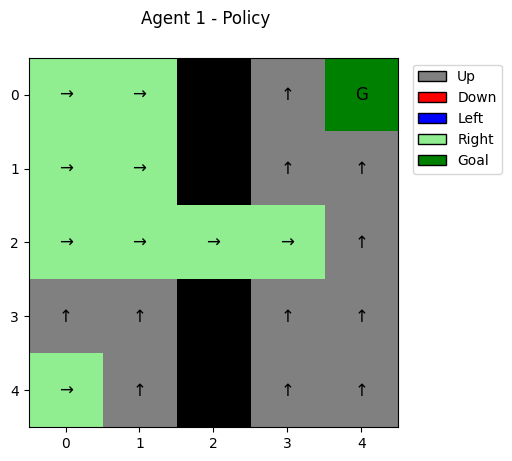

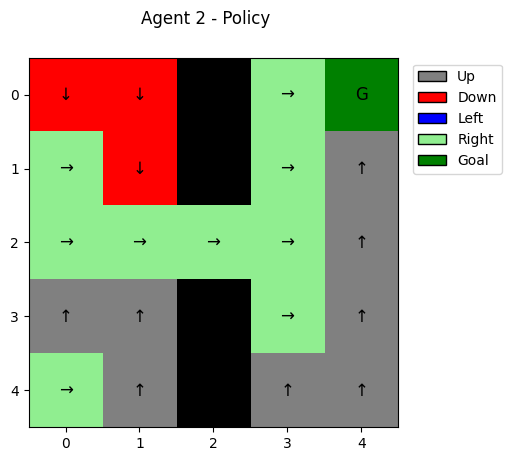

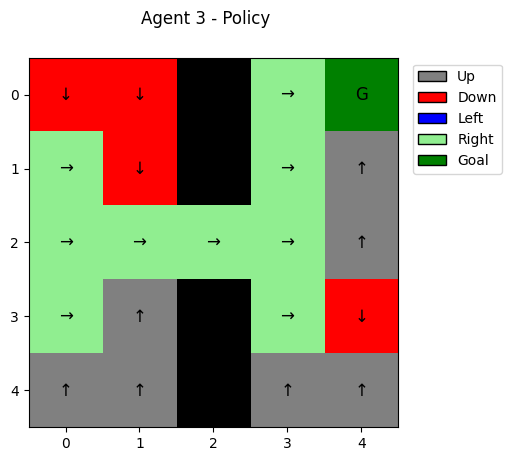

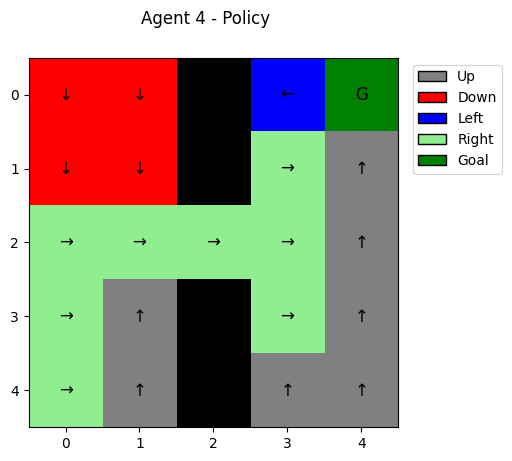

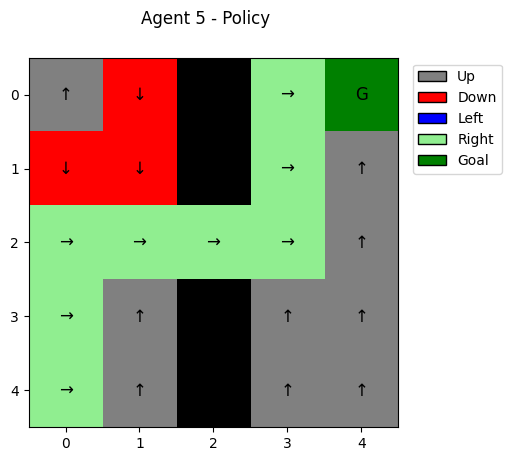

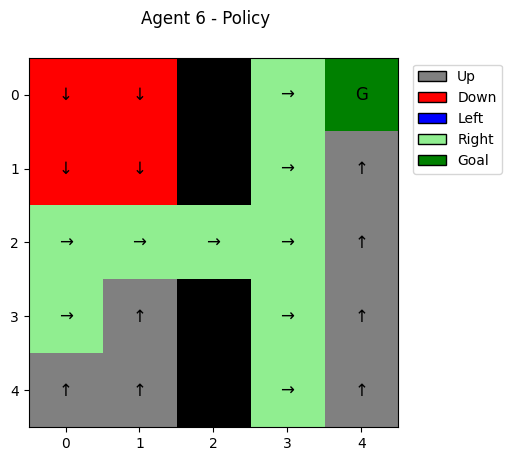

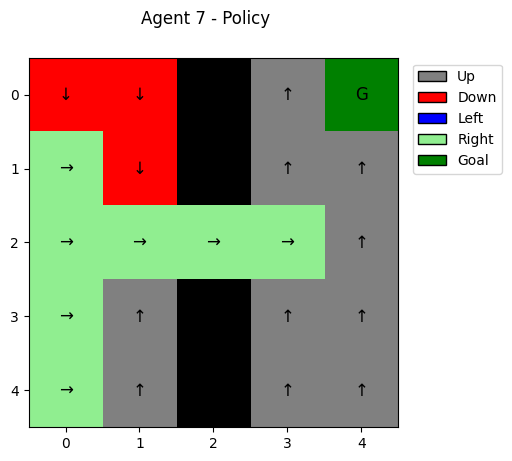

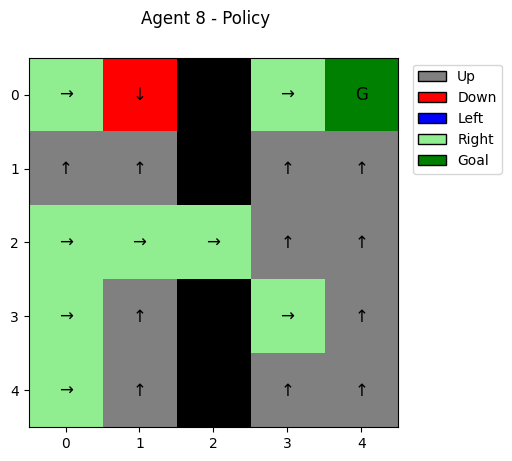

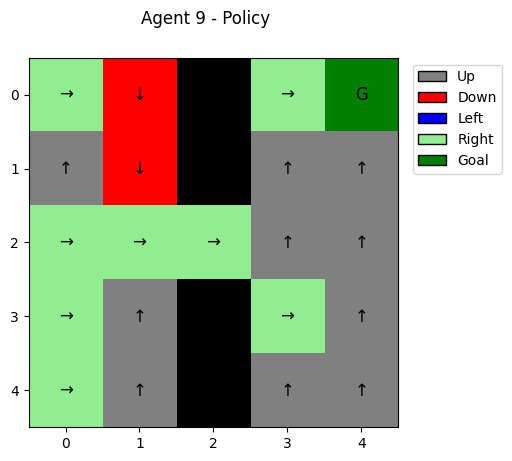

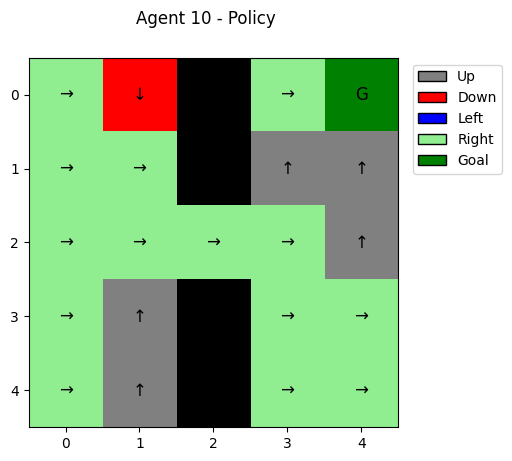

In [10]:
for i in range(len(agents_arr)):
    #print("Agent", i+1, "value grid:")
    #print(value_grids[i])
    #print("Agent", i+1, "policy grid:")
    #print(policy_grids[i])
    #print("Agent", i+1, "policy grid string:")
    #print(string_policy_grids[i])
    fig = plot_string_policy(string_policy_grids[i])
    fig.suptitle(f'Agent {i+1} - Policy')
plt.show()

In [11]:
#load the weights from file

#Hay que tener cuidado de darle correctamente el mismo tamaño de capas que al modelo que se quiere cargar
agent_replay = DDQNAgent(state_size=env.observation_space.shape[0],action_size=env.action_space.n,seed=0, fc1_unit=128, fc2_unit=128)
agent_replay.qnetwork_local.load_state_dict(torch.load('../data/models/DDQNagent4.pt'))
agent_replay.qnetwork_local.eval()

with open(f"../data/csv/historyDQN.csv", 'a') as f:
    #f.write(f"step,y,x,action,next_y,next_x,reward,done\n")
    for i in range(1):
        obs, _ = env.reset()

        t = 0
        done = False
        while not done:
            action = agent_replay.act(obs)
            prev_state = [obs[0], obs[1], action]
            obs, rew, done, _, _ = env.step(action)

            #f.write(f"{t},{prev_state[0]},{prev_state[1]},{prev_state[2]},{obs[0]},{obs[1]},{rew},{done}\n")
            t += 1
        print("Agente", i+1, "terminado en", t, "pasos")


Agente 1 terminado en 8 pasos
